# Abraia - Getting started with image classification

In [21]:
%%capture
!python -m pip install abraia
!python -m pip install wget

import os
if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import matplotlib.pyplot as plt
from abraia import Abraia, deep
 
abraia = Abraia()

# Cats and Dogs transfer learning

Download the cats and dogs dataset and plot some random images.

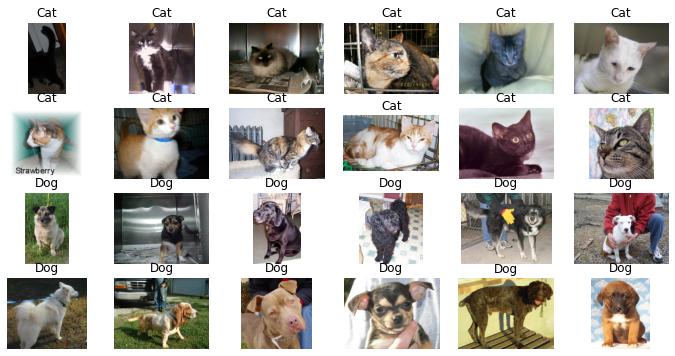

In [28]:
cat_paths, dog_paths, labels = deep.load_dataset(dataset='cats-and-dogs')

cats = np.random.choice(cat_paths, 12)
dogs = np.random.choice(dog_paths, 12)
data = np.concatenate((cats, dogs))
names = 12 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 4, 6
plt.figure(figsize=(12, 6))
for k, (src, label) in enumerate(zip(data, names)):
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(plt.imread(src))
    plt.axis('off')

Split some data for testing and validation.

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

def split_train_test(cat_paths, dog_paths, train_ratio=0.7):
    cats_train, cats_test = train_test_split(cat_paths, test_size=1-train_ratio)
    dogs_train, dogs_test = train_test_split(dog_paths, test_size=1-train_ratio)
    folders = ['train', 'test', 'train/Cat', 'train/Dog', 'test/Cat', 'test/Dog']
    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)
    for cat_train in cats_train:
        shutil.move(cat_train, 'train/Cat')
    for dog_train in dogs_train:
        shutil.move(dog_train, 'train/Dog')
    for cat_test in cats_test:
        shutil.move(cat_test, 'test/Cat')
    for dog_test in dogs_test:
        shutil.move(dog_test, 'test/Dog')
    return 'train', 'test'

TRAIN_DIR, TEST_DIR = split_train_test(cat_paths, dog_paths)

## Data augmentation

Prepare training data for data augmentation and plot some resulting images.

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


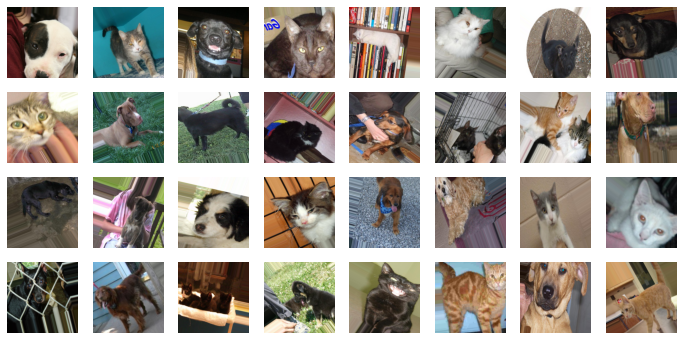

In [41]:
from abraia.deep import ImageDataGenerator, preprocess_input

target_size = (299, 299)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [ ]:
MODEL_FILE = 'filename.model'

model = deep.create_model()
history = deep.train_model(model, train_generator, validation_generator)
model.save(MODEL_FILE)

deep.plot_train_history(history)

## Prediction of the custom model

In [43]:
import matplotlib.gridspec as gridspec

def plot_preds(img, preds, labels):
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
model = deep.load_model(MODEL_FILE)

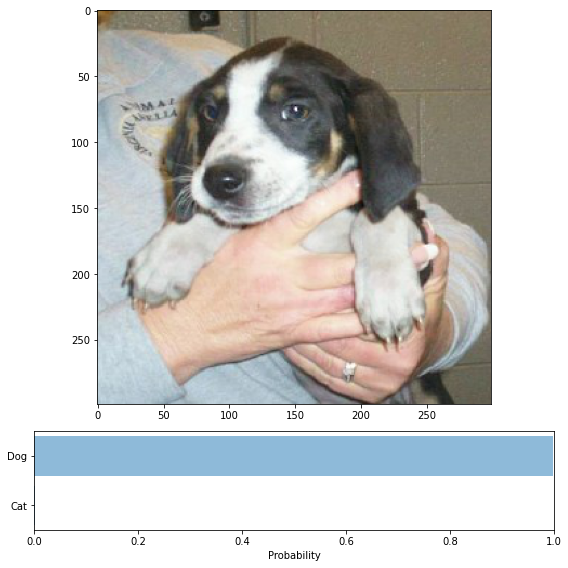

In [47]:
img = np.asarray(deep.load_img('test/Dog/10.jpg', target_size=target_size))
preds = deep.predict_model(model, img)

plot_preds(img, preds, labels)